In [1]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
plt.ioff()
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm
from __future__ import division

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


$x_{t+1} = (A + pB)x_t + Cu_{t+1}$

In [2]:
def passivity(t,k=0.05,t0=400):
    return 1/(1+np.exp(-k*(t-t0)))

def diag_idx(n):
    return [i for i in range(n)],[i for i in range(n)]

def makeStableMatrix(n, density=0.1):
    # TODO: implement on GPU?
    eig = np.diag(np.random.uniform(-1,0,n))
    v = scipy.linalg.orth(np.random.uniform(-1,1,(n,n)))
    A = np.matmul(np.matmul(v.T, eig), v)
    # need to make A sparse
    indices = np.reshape(np.indices((n,n)),[2,-1])
    mask = np.eye(n)
    # may create density slightly less than desired if choice is on diagonal
    idx = indices[:,np.random.choice(np.arange(indices.shape[1]),int(np.ceil(density*n**2-n)),replace=False)]
    mask[idx[0], idx[1]] = 1
    A[np.logical_not(mask)] = 0
    return A

def step(A,B,C,u,p,x,dt=1):
    dxdt = T.matmul((A + p*B), x) + C * u
    return dxdt + x

def step_batch(A,B,C,u,p,x,dt=1):
    dxdt = (T.matmul((A + p[:,None,None]*B), x[:,:,None])).squeeze() + u[:,None]*C
    return dxdt + x

def sim(A,B,C,u,p,x0,e=0.05):
    ntime = u.shape[0]
    nfeatures = x0.shape[0]
    time = T.arange(ntime,dtype=T.int32)
    x = T.zeros(ntime, x0.shape[0]).cuda()
    z = T.zeros(nfeatures).cuda()
    x[0] = x0
    for t in range(1,ntime):
        if e==0:
            x[t] = step(A,B,C,u[t],p[t],x[t-1])
        else:
            x[t] = step(A,B,C,u[t],p[t],x[t-1]) + T.normal(z,e).cuda()
    return x

def generate_data(sim_time, nstim,nfeatures, burn_in=400, test_time=200, e=0.01, k=0.05, t0=400, density=0.2):
    ntime = sim_time+burn_in+test_time
    time = T.from_numpy(np.arange(ntime)).cuda()
    A_true = T.from_numpy(makeStableMatrix(nfeatures,density).astype(np.float32)).cuda()
    B_true = T.from_numpy(makeStableMatrix(nfeatures,density).astype(np.float32)).cuda()
    C_true = T.from_numpy(np.random.normal(0,0.05,nfeatures).astype(np.float32)).cuda()
    # C_true = T.from_numpy(makeStableMatrix(nfeatures).astype(np.float32)).cuda()
    x0 = T.from_numpy(np.random.normal(0,0.05,nfeatures).astype(np.float32)).cuda()
    u = T.zeros(ntime).cuda()
    u[np.arange(4,ntime,ntime/nstim)] = 1

    p1 = np.vectorize(partial(passivity,k=k,t0=t0))
    time = np.arange(ntime)
    p_true = p1(time).astype(np.float32)
    p_true = T.from_numpy(p_true).cuda()
#     p_true = T.zeros(ntime).cuda() # TODO remove me
    x_true = sim(A_true,B_true,C_true,u,p_true,x0,e)
    train = (time[burn_in:-test_time], u[burn_in:-test_time],
             p_true[burn_in:-test_time], x_true[burn_in:-test_time])
    test = (time[-test_time:], u[-test_time:], p_true[-test_time:], x_true[-test_time:])
    return A_true, B_true, C_true, train, test

In [3]:
class FishData(Dataset):    
    def __init__(self, u, p, x):
        self.x = nn.Parameter(x,requires_grad=False)
        self.p = nn.Parameter(p,requires_grad=False)
        self.u = nn.Parameter(u,requires_grad=False)
        self.nfeatures = x.shape[1]
        
    def __len__(self):
        return len(self.x) - 1

    def __getitem__(self, idx):
        x_next_indices = idx+1
        return (self.u[idx], self.p[idx],
                self.x[idx], self.x[x_next_indices])

class FishSeqData(Dataset):    
    def __init__(self, u, p, x,n_future_steps=1):
        self.x = nn.Parameter(x,requires_grad=False)
        self.p = nn.Parameter(p,requires_grad=False)
        self.u = nn.Parameter(u,requires_grad=False)
        self.nfeatures = x.shape[1]
        self.n_future_steps = n_future_steps
        
    def __len__(self):
        return len(self.x)-self.n_future_steps

    def __getitem__(self, idx):
        indices = slice(idx,idx+self.n_future_steps)
        x_true_indices = slice(idx+1,idx+self.n_future_steps+1)
        return (self.u[indices], self.p[indices],
                self.x[indices], self.x[x_true_indices])

class DynamicsSeq(nn.Module):
    def __init__(self, nfeatures, n_future_steps,dtype=T.float32, scale=1,std=0.1):
        super(DynamicsSeq, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
                
        self.A = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.B = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.C = nn.Parameter(tensor(nfeatures).normal_(std),requires_grad=True)
        self.n_future_steps = n_future_steps
        self.tensor = tensor
        self.scale = scale
        self.dtype = dtype

    def forward(self, u, p, x_true, n_future_steps=None):
        if n_future_steps==None:
            n_future_steps = self.n_future_steps
        x = self.tensor(x_true.shape[0], 1+x_true.shape[1], *x_true.shape[2:]).zero_()
        x[:,0] = x_true[:,0]
        for t in range(n_future_steps):
            u[ :,t,None]*self.C
            dxdt = (T.matmul((self.A + p[:,t,None,None]*self.B), x_true[:,t,:,None]).squeeze()) + u[ :,t,None]*self.C
            x[:,t+1] = dxdt + x[:,t]
        return x[:,1:]
    
    def predict(self, u, p, x_init, n_future_steps=1):
        with T.no_grad():
            x = self.tensor(1+u.shape[0], x_init.shape[0]).zero_()
            x[0] = x_init
            for t in range(n_future_steps):
                u[t,None]*self.C
                dxdt = (T.matmul((self.A + p[t,None,None]*self.B), x[t,:,None]).squeeze()) + u[t,None]*self.C
                x[t+1] = dxdt + x[t]
        return x[1:]

class DynamicsSequence(nn.Module):
    def __init__(self, nfeatures,dtype=T.float32, scale=1,std=0.1):
        super(DynamicsSequence, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
        
        self.A = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.B = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.C = nn.Parameter(tensor(nfeatures).normal_(std),requires_grad=True)

    def forward(self, u, p, x, x_true):
        "u: float, p: float, x: vector, x_true: vector"
        return x + T.matmul((self.A + p*self.B), x_true) + u * self.C
    
    def predict(self, u, p, x_init):
        with T.no_grad():
            x = T.cuda.FloatTensor(1+u.shape[0], x_init.shape[0]).zero_()
            x[0] = x_init
            n_future_steps = u.shape[0]
            for t in range(n_future_steps):
                dxdt = T.matmul((self.A + p[t]*self.B), x[t]) + u[t] * self.C
                x[t+1] = dxdt + x[t]
        return x[1:]

    
class Dynamics(nn.Module):
    def __init__(self, nfeatures):
        super(Dynamics, self).__init__()
        self.A = nn.Parameter(T.normal(T.zeros(nfeatures,nfeatures),0.5),requires_grad=True)
        self.B = nn.Parameter(T.normal(T.zeros(nfeatures,nfeatures),0.5),requires_grad=True)
        self.C = nn.Parameter(T.normal(T.zeros(nfeatures),0.5),requires_grad=True)

    def forward(self, u, p, x):
        return (x[:,0] + (T.matmul((self.A + p[:,0,None,None]*self.B), x[:,0,:,None]).squeeze()) + u[:,0,None] * self.C)[:,None]


def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6), lambdaC=(1e-5, 1e-5), lr=0.1, verbose=True):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    if verbose:
        A_loss = F.mse_loss(model.A.data,A_true)
        print("A_loss: {}".format(A_loss))
    cum_mse_loss = 0
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            cum_mse_loss += F.mse_loss(X_pred.float(),X_true.float())
    print("mse_loss: {:3E}".format(cum_mse_loss/len(dataloader)))
#     optimizer = T.optim.SGD(model.parameters(),lr=lr)
    optimizer = T.optim.Adam(model.parameters(),lr=lr,amsgrad=True)
    for e in range(nepochs):
        if verbose:
            print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_mse_loss = 0
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            l_A = lambdaA[0] * model.A.norm(1) + lambdaA[1] * model.A.norm(2)
            l_B = lambdaB[0] * model.B.norm(1) + lambdaB[1] * model.B.norm(2)
            l_C = lambdaC[0] * model.C.norm(1) + lambdaC[1] * model.C.norm(2)
            mse_loss = F.mse_loss(X_pred,X_true)
            loss = mse_loss + l_A + l_B + l_C

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_mse_loss += float(mse_loss)
            del X_pred, U,P,X, X_true, mse_loss, l_A, l_B, loss
            gc.collect()
            torch.cuda.empty_cache()

        if verbose:
            A_loss = F.mse_loss(model.A.data,A_true)
            B_loss = F.mse_loss(model.B.data,B_true)
            C_loss = F.mse_loss(model.C.data,C_true)
            print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        print("cum_loss: {:3E}, mse_loss: {:3E}".format(cum_loss,cum_mse_loss/len(dataloader)))
    
    if verbose:
        print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))

def set_grad(params, params_with_grad):

    for param, param_w_grad in zip(params, params_with_grad):
        if param.grad is None:
            param.grad = torch.nn.Parameter(param.data.new().resize_(*param.data.size()))
        param.grad.data.copy_(param_w_grad.grad.data)
    
def train_fp16(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6), lr=0.1, verbose=True,loss_scale=1):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    param_copy = [param.clone().type(torch.cuda.FloatTensor).detach() for param in model.parameters()]
    for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            mse_loss = F.mse_loss(X_pred.float(),X_true.float())
            print("pred loss: {}".format(mse_loss))
            break
    
    if verbose:
        A_loss = F.mse_loss(param_copy[0].data/model.scale,A_true)
        print("A_loss: {}".format(A_loss))
#         optimizer = T.optim.SGD(model.parameters(),lr=lr)
    for param in param_copy:
        param.requires_grad = True
    optimizer = torch.optim.SGD(param_copy, lr)
#     optimizer = T.optim.Adam(param_copy,lr=lr)
    nfeatures = model.A.shape[0]
#     nondiagonal = ~T.eye(nfeatures,dtype=T.uint8)
    for e in range(nepochs):
        if verbose:
            print("epoch {}: ".format(e), end="")
        cum_loss = 0
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            l_A = lambdaA[0] * model.A.float().norm(1) + lambdaA[1] * model.A.float().norm(2)
            l_B = lambdaB[0] * model.B.float().norm(1) + lambdaB[1] * model.B.float().norm(2)
#             l_A = lambdaA[0] * model.A[nondiagonal].float().norm(1) + lambdaA[1] * model.A[nondiagonal].float().norm(2)
#             l_B = lambdaB[0] * model.B.float().norm(1) + lambdaB[1] * model.B.float().norm(2)

            mse_loss = F.mse_loss(X_pred,X_true).float()
            loss = (mse_loss + l_A + l_B) * loss_scale

            model.zero_grad()
            loss.backward()
            set_grad(param_copy, list(model.parameters()))
            if loss_scale != 1:
                for param in param_copy:
                    param.grad.data = param.grad.data/loss_scale
            optimizer.step()
            params = list(model.parameters())
            for i in range(len(params)):
                params[i].data.copy_(param_copy[i].data)

            cum_loss += float(loss)/loss_scale
    #             del X_pred, U,P,X, X_true, mse_loss, l_A, l_B, loss
    #             gc.collect()
    #             torch.cuda.empty_cache()

        if verbose:
            A_loss = F.mse_loss(param_copy[0].data/model.scale,A_true)
            B_loss = F.mse_loss(param_copy[1].data/model.scale,B_true)
            C_loss = F.mse_loss(param_copy[2].data/model.scale,C_true)
            print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        print("pred_loss: {}".format(cum_loss))

    if verbose:
        print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))

def predict(model,data, batch_size=32):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    with T.no_grad():
        pred = T.cuda.FloatTensor(len(data),*data[0][2].shape).zero_()
        for i, batch_data in enumerate(tqdm(dataloader)):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            pred[i*batch_size:(i+1)*batch_size] = X_pred
    return pred



def model_v_truth(model,u,p,x_true,A_true=None, B_true=None):
    if model.dtype==T.float16:
        A = model.A.data.float()*model.scale
        B = model.B.data.float()*model.scale
    else:
        A = model.A.data
        B = model.B.data
    x_pred = predict(model,data).squeeze()
    fig = plt.figure(figsize=(10,10))
    spec = gridspec.GridSpec(ncols=2, nrows=3)
    anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                     va='center', ha='center')

    ax1 = fig.add_subplot(spec[0,0:])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[1, 1])
    ax4 = fig.add_subplot(spec[2, 0])
    ax5 = fig.add_subplot(spec[2, 1])
    
    dx_pred = x_pred - x_true[:-1]
#     ax1.plot(dx_pred.mean(1).cpu().numpy(),color='red', label="Model")
    ax1.plot(x_pred[:,2].cpu().numpy(),color='red', label="Model")
    ax1.set_ylabel("dx/dt")
    ax1.set_xlabel("Time")
    ax1.set_title("Witheld test data")
    dx_true = x_true[1:] - x_true[:-1]
    ax1.plot(dx_true.mean(1).cpu().numpy(),color="gray",linewidth=5, alpha=0.7,label="Truth")
    ax1.legend()
    
    if not A_true==None:
        mymax = max(A_true.max(), A.max())
        mymin = min(A_true.min(), A.min())
        im = ax2.imshow(A_true.cpu(),vmin=mymin,vmax=mymax)
        ax2.set_title("A true")
        ax3.imshow(A.cpu(),vmin=mymin,vmax=mymax)
        ax3.set_title("A model")
    else:
        ax3.imshow(A.cpu())
#     cax,kw = mpl.colorbar.make_axes([ax2, ax3])
#     fig.colorbar(im, cax=cax, **kw)
    
    if not B_true==None:
        mymax = max(B_true.max(), B.max())
        mymin = min(B_true.min(), B.min())
        im2 = ax4.imshow(B_true.cpu(),vmin=mymin,vmax=mymax)
        ax4.set_title("B true")
        ax5.imshow(B.cpu(),vmin=mymin,vmax=mymax)
        ax5.set_title("B model")
    else:
        ax5.imshow(B.cpu())
#     cax,kw = mpl.colorbar.make_axes([ax4, ax5])
#     fig.colorbar(im2, cax=cax, **kw)
    
    fig.tight_layout()
    return fig

- reg on C
- what does A look like?
- what does held-out look like?
- multiple steps

# Fish code

### Augment the PythonPath so python can find necessary code.

In [4]:
import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

### Import useful python packages

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pims
import numpy as np
import pandas as pd
import scipy
import skimage.io
import visualization_utils as vizutil
import seaborn as sns
from skimage.filters import gaussian_filter

### Load the data

passivity_2p_imaging_utils provides a list of all the datasets and provides a helper class to make loading the data easy.

The data_sets are split into three conditions... (the keynames are wierd for historical reasons)   
'enp': control group - no shocks at all.  
'c': experimental group - fish experience behavioral challenge (repeated shocks) while being imaged  
'e': reexposed group - first fish experience free-swimming behavioral challenge... then are imaged during behavioral challenge
  
all_data is a dictionary keyed by the condition.  
all_data[condition] contains a list of Passivity_2p_Fish objects.

In [6]:
import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

print('controls, n =', len(all_data['enp']))
print('experimental, n =', len(all_data['c']))
print('reexposed, n =', len(all_data['e']))

controls, n = 6
experimental, n = 8
reexposed, n = 12


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Some ideal example fish for modeling
(see 2p_Fish_Figure3_Accumulation.ipynb)

In [7]:
print('experimental', all_data['enp'][5].fishid)
print('experimental', all_data['c'][6].fishid)
print('reexposed', all_data['e'][2].fishid)

experimental f01736
experimental f01606
reexposed f01555


### Passivity_2p_Fish Class

The `Passivity_2p_Fish` class offers various members and methods for loading data associated with each fish.  
  
Lets demo these methods using an example fish:  

In [8]:
f = all_data['e'][2]

The time of all volumes, tail_movements, and shocks are stored in the following variable:

In [9]:
print('The first shock started at t=', f.get_shock_start_time(), 's')#shock start times
print('The first slice of the frame began being imaged at t=', f.frame_st[0,0], 's') #time at which each slice was imaged [#samples X #slices]
print('The first tail movement started at=', f.tail_movement_start_times[0], 's') #tail movement times - movements separted into forward swims, turns and escapes.
print('Num z-planes imaged:', f.num_zplanes)
print('Volume-Rate:', 1/np.diff(f.frame_st[:,0]).mean()) #frame_st is #frames x #slices, we examine interval between imaging first slice

The first shock started at t= 448.9964299699543 s
The first slice of the frame began being imaged at t= 12.446 s
The first tail movement started at= 102.5907 s
Num z-planes imaged: 11
Volume-Rate: 1.0131832172386757


Demo code for examining movie of tail (slowed by factor of 5)

In [10]:
movement_ndx = 10
clip = f.get_tail_movie_clip(f.tail_movement_start_times[movement_ndx]-.1, 
                             f.tail_movement_end_times[movement_ndx]+.1, 
                             playback_speed_factor=.2)
clip.ipython_display(width=150)

100%|██████████| 291/291 [00:00<00:00, 4504.93it/s]


Demo code to plot tail movement rate

Text(0.5,0,'Time Relative to First Shock (s)')

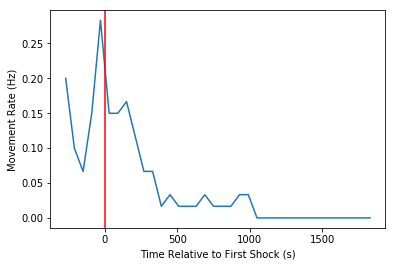

In [11]:
rate_window_starts = np.arange(-300,31*60,60) + f.get_shock_start_time() #1 minutes windows around start of shock
rate_window_centers = rate_window_starts + 30
rate_windows_adj = rate_window_starts - f.td_time[0] #corrected for the fact that get_movement_rate wants time relative to start of tail imaging.
plt.plot(rate_window_centers - f.get_shock_start_time(), [f.get_movement_rate([x,x+60], bExcShockResp=False) for x in rate_windows_adj])
plt.axvline(0,c='r')
plt.ylabel('Movement Rate (Hz)')
plt.xlabel('Time Relative to First Shock (s)')

The `get_roi_table` method returns a dataframe of all the rois for teh fish.  Each row of this table represents an ROI and specified the place the ROI is in, the pixels that are included in the ROI, the centroid of the ROI, and which brain regions the ROI is in.  

Note, this data is older and was processed by simply segmenting the anatomical images.  Thus the data is does not look as clean as data that is cleaned up and processed using CNMF, for example.

In [12]:
df = f.get_roi_table() #this can be slow to run the first time as data is loaded from files
df.head()

,fishid,z,zndx,roi_img_label,coords,centroid_x,centroid_y,area,solidity,eccentricity,...,in_l_tel,in_r_ctel,in_l_LHb,in_l_MHb,in_r_vthal,in_r_MHb,in_l_dthal,region,hemisphere,region_bilat
0,f01555,0,0,1,"[[1, 27], [1, 28], [2, 26], [2, 27], [2, 28], ...",2.200000,27.200000,10,0.909091,0.828852,...,False,False,False,False,False,False,False,other,w,other
1,f01555,0,1,2,"[[1, 56], [1, 57], [1, 58], [1, 59], [1, 60], ...",1.923077,57.692308,13,1.000000,0.774346,...,False,False,False,False,False,False,False,other,w,other
2,f01555,0,2,3,"[[1, 61], [1, 62], [1, 64], [1, 65], [2, 62], ...",2.076923,63.461538,13,0.764706,0.872165,...,False,False,False,False,False,False,False,other,w,other
3,f01555,0,3,4,"[[1, 83], [1, 84], [1, 85], [1, 86], [2, 82], ...",2.076923,84.384615,13,0.928571,0.656671,...,False,False,False,False,False,False,False,other,w,other
4,f01555,0,4,5,"[[1, 87], [1, 88], [1, 89], [1, 90], [1, 91], ...",3.517857,90.446429,56,0.767123,0.888139,...,False,False,False,False,False,False,False,l_wholebrain,l,wholebrain


'get_signals_raw' returns a matrix containing the raw fluorescent signal associated with each ROI.  Each row of this matrix is associated with the corresponding row of the ROI table.  

Note, I only use the second half of the signal matrix, because the agarose had not fully hardened during the first of imaging which cause the fish to drift in z slightly.

In [13]:
M = f.get_signals_raw(z=None)
#M = hbutils.df_over_f(M)
print('Num ROIs:', df.shape[0])
print('Shape of signal matrix', M.shape)

Num ROIs: 15888
Shape of signal matrix (15888, 2826)


There are also various methods for grabbing the raw imaging data:  
get_tif_as_vol  
get_tif_rasl

We can use this to visualize a few ROIs in particular plane/slice and brain region:

multi


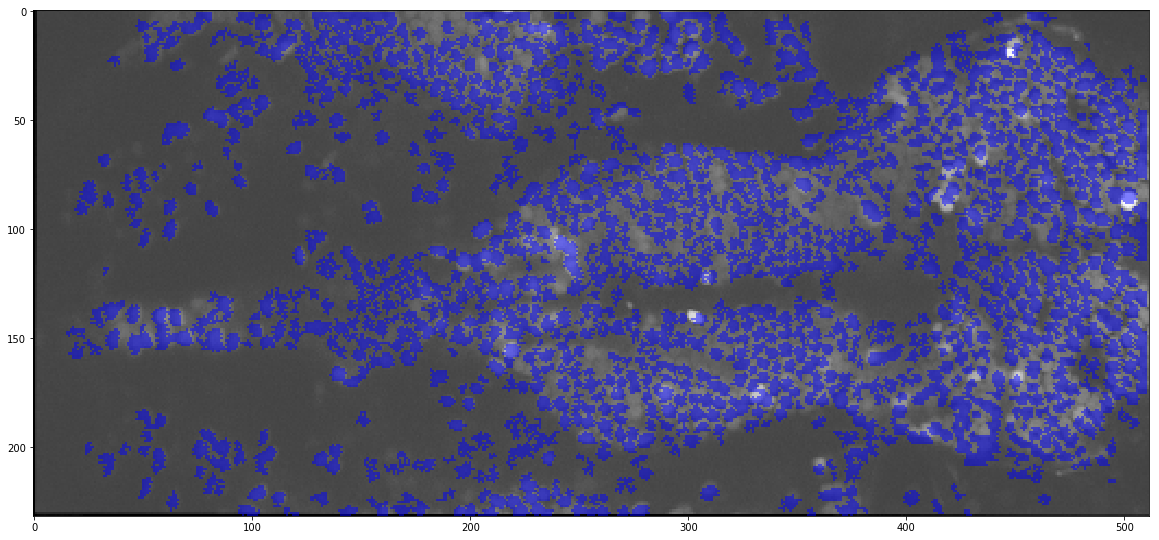

In [14]:
z=10

#Create a background image by averaging 200 frames and adjusting the gamma.
back_img = np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4)

#Select rois in raphe in this slices, and get their coordinates.
coords = df[(df.z==z)].coords

#Overlay the ROIs on the background image and display:
img = vizutil.overlay_coords(back_img, coords, [0,0,1], alpha=.5)
plt.figure(figsize=[20,20])
plt.imshow(img,interpolation='nearest')

In [15]:
def get_poly_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def get_roi_area(poly_coords):
    """Get area of an rois.
    Args:
    poly_coords: is numpy matrix #vertices x 2.  NAN rows mean coords separates multiple polygons.
    """
    #split poly_coords into list of polys based on nan rows
    poly_list = np.split(poly_coords, np.where(np.isnan(poly_coords).any(axis=1))[0])
    
    #clean up by removing nan rows
    poly_list = [poly[~np.isnan(poly).any(axis=1)] for poly in poly_list] #remove nan
    
    areas = [get_poly_area(poly[:,0],poly[:,1]) for poly in poly_list]
    return sum(areas)

def get_cnmf_rois_in_region(self, z, region_name):
    #return bool array of length num rois in plane. true if in region.
    centroids = self.get_roi_centroids(z)
    region_polys = self.region_polys
    poly = region_polys[region_name]['polys'][z]
    if len(poly) < 3:
        return np.zeros(centroids.shape[0],dtype=bool)
    else:
        return mpl.path.Path(poly).contains_points(centroids)
    
def get_cnmf_roi_table_and_signals(self, z=None, region=None):
    #z indexed from 0
    assert(z==None or region==None)
    if not hasattr(self, '_df_cnmf_all_rois'):
        region_polys = self.region_polys
        self._df_cnmf_all_rois = pd.DataFrame()
        self._cnmf_signals_all = []

        for nz in xrange(self.num_zplanes):
            #Load CNMF results for each plane
            fn_cnmf = self.data_prefix+'_plane%d_cnmf_final.npz'%(nz+1)
            d = np.load(fn_cnmf)
            contours = d['contours']
            centroids = np.array([roi['CoM'] for roi in contours])
            #Not some ROIs are not contigous... are split in two or more parts.
            #In this case there is an NaN row in the poly list to separate sections
            #the poly area funciton handles this.

            #Add to dataframe
            df_rois = pd.DataFrame()
            df_rois['fishid'] = [self.fishid]*len(contours)
            df_rois['z'] = np.ones(len(contours), dtype=int)*nz
            df_rois['zndx'] = np.arange(len(contours), dtype=int)
            df_rois['poly'] = [contour['coordinates'] for contour in contours]
            df_rois['centroid_x'] = centroids[:,0]
            df_rois['centroid_y'] = centroids[:,1]
            df_rois['area'] = [get_roi_area(contour['coordinates']) for contour in contours]
            for region_name in region_polys:
                region_poly = region_polys[region_name]['polys'][nz]
                if len(region_poly) < 3:
                    region_bndx = np.zeros(centroids.shape[0],dtype=bool)
                else:
                    region_bndx = mpl.path.Path(region_poly).contains_points(centroids)
                df_rois['in_'+region_name] = region_bndx
            self._df_cnmf_all_rois = self._df_cnmf_all_rois.append(df_rois, ignore_index=True)

            self._cnmf_signals_all.append(d['C'])


        #Convert boolean region columsn to a column containing region name
        reg_columns = [item.startswith('in_') for item in self._df_cnmf_all_rois.columns]
        temp = np.array(self._df_cnmf_all_rois.ix[:,reg_columns])
        reg_ndx = np.array([np.where(row)[0][0] if len(np.where(row)[0])>0 
                                                else np.nan for row in temp])
        reg_names = np.array([name[3:] for name in self._df_cnmf_all_rois.columns[reg_columns]])
        reg_names = np.hstack([reg_names,['other']])
        reg_ndx[np.isnan(reg_ndx)] = len(reg_names)-1
        self._df_cnmf_all_rois['region'] = reg_names[reg_ndx.astype(int)]

        #Split region in a hemisphere and bilateral region name
        self._df_cnmf_all_rois['hemisphere'] = [reg[:1] if (reg.startswith('l_') or reg.startswith('r_')) 
                                       else 'w' for reg in self._df_cnmf_all_rois['region']]
        self._df_cnmf_all_rois['region_bilat'] = [reg[2:] if (reg.startswith('l_') or reg.startswith('r_')) 
                                               else reg for reg in self._df_cnmf_all_rois['region']]

        #stack signals
        self._cnmf_signals_all = np.vstack(self._cnmf_signals_all)

    if z is not None:
        bndx = self._df_cnmf_all_rois['z']==z
    elif region is not None:
        bndx = self._df_cnmf_all_rois['in_'+region]==True
    else:
        bndx = np.ones(self._df_cnmf_all_rois.shape[0], dtype=bool)

    return self._df_cnmf_all_rois[bndx].copy(), self._cnmf_signals_all[bndx,:].copy()


multi


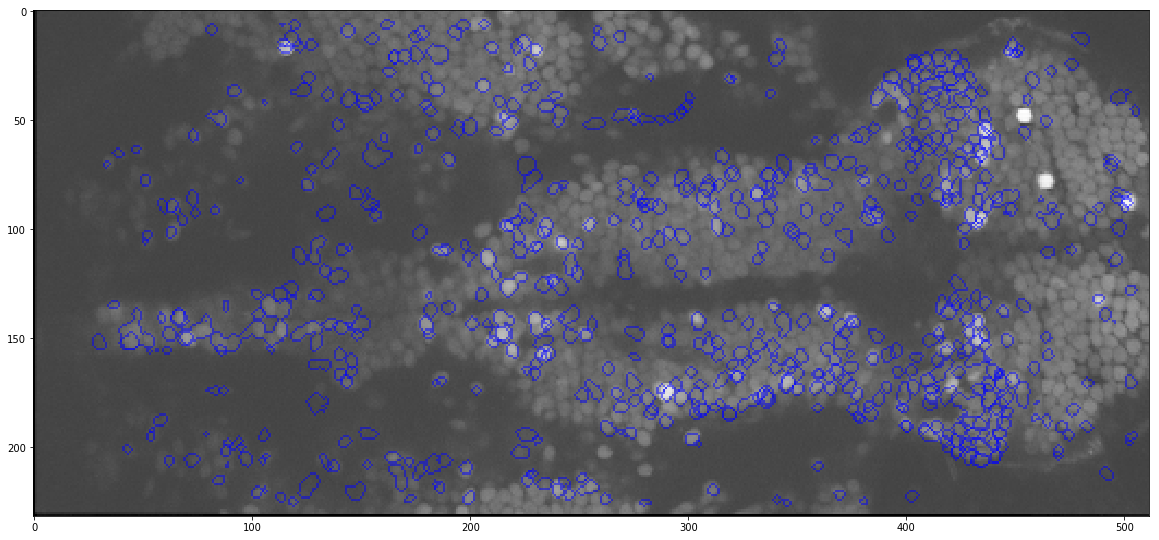

In [16]:
z=9
df, sig = f.get_cnmf_roi_table_and_signals()

#Create a background image by averaging 200 frames and adjusting the gamma.
back_img = np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4)

#Select rois in raphe in this slices, and get their coordinates.
poly_coords = df[(df.z==z)].poly
poly_coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]

#Overlay the ROIs on the background image and display:
img = vizutil.overlay_coords(back_img, poly_coords, [0,0,1], alpha=.5)
plt.figure(figsize=[20,20])
plt.imshow(img,interpolation='nearest')

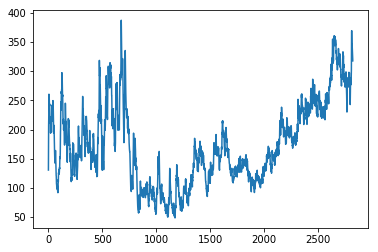

In [17]:
df, sig = f.get_cnmf_roi_table_and_signals()
bndx = (df.in_r_MHb) & (df.z==4)
plt.plot(sig[bndx,:].mean(axis=0))

# Real data

In [18]:
from pandas import DataFrame

In [19]:
def moving_average(a, n=3) :
    ret = np.cumsum(a,0)
    ret[n:] = ret[n:] - ret[:-n]
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=6,span=6):
    u = moving_average(x,ma_window)
    return ewma((x - u)/u, span)

In [20]:
dff = T.from_numpy(sig.T.astype(np.float32)).cuda()
# M_T = T.from_numpy(M[bndx].T)
# dff_norm = (dff - dff.mean(0))/(dff.std(0)+1e-8)
# M_norm = (M_T - M_T.mean(0))/(M_T.std(0)+1e-8)

In [21]:
dtype = np.float32
x_fish = F.normalize(dff,0)
time_fish = T.from_numpy(f.frame_st.mean(1).astype(dtype)).cuda()
if dtype==np.float16:
    u_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
    p_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
else:
    u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
    p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
u_fish[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1

In [31]:
ntrain = int(np.floor(len(x_fish)*0.8))
data = FishData(u_fish[:ntrain],p_fish[:ntrain],x_fish[:ntrain])
train_data = (u_fish[:ntrain],p_fish[:ntrain],x_fish[:ntrain])
test_data = (u_fish[ntrain:],p_fish[ntrain:],x_fish[ntrain:])
model = DynamicsSequence(data.nfeatures)

In [32]:

class DynamicsSequence(nn.Module):
    def __init__(self, nfeatures,dtype=T.float32, scale=1,std=0.1):
        super(DynamicsSequence, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
        
        self.A = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.B = nn.Parameter(tensor(nfeatures,nfeatures).normal_(std),requires_grad=True)
        self.C = nn.Parameter(tensor(nfeatures).normal_(std),requires_grad=True)

    def forward(self, u, p, x, x_true):
        "u: float, p: float, x: vector, x_true: vector"
        return x + T.matmul((self.A + p*self.B), x_true) + u * self.C
    
    def predict(self, u, p, x_init):
        with T.no_grad():
            x = T.cuda.FloatTensor(1+u.shape[0], x_init.shape[0]).zero_()
            x[0] = x_init
            n_future_steps = u.shape[0]
            for t in range(n_future_steps):
                x[t+1] = self(u[t], p[t], x[t], x[t])
        return x[1:]
    
def trainSequence(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6), lambdaC=(1e-5, 1e-5), lr=0.1, verbose=True):
    dataloader = DataLoader(data, batch_size=1, shuffle=False)
    if verbose:
        A_loss = F.mse_loss(model.A.data,A_true)
        print("A_loss: {}".format(A_loss))
    cum_mse_loss = 0
    # optimizer = T.optim.SGD(model.parameters(),lr=lr)
    optimizer = T.optim.Adam(model.parameters(),lr=lr,amsgrad=True)
    for e in range(nepochs):
        if verbose:
            print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_mse_loss = 0
        not_init = True
        for batch_data in tqdm(dataloader):
            U,P,X_prev, X_next = batch_data
            X_prev = X_prev[0]
            if not_init:
                X_cum = X_prev
                not_init = False
            X_next = X_next[0]
            X_pred = model(U,P,X_cum, X_cum)
            l_A = lambdaA[0] * model.A.norm(1) + lambdaA[1] * model.A.norm(2)
            l_B = lambdaB[0] * model.B.norm(1) + lambdaB[1] * model.B.norm(2)
            l_C = lambdaC[0] * model.C.norm(1) + lambdaC[1] * model.C.norm(2)
            mse_loss = F.mse_loss(X_cum,X_next)
            loss = mse_loss + l_A + l_B + l_C

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            X_cum = X_pred.detach()
            cum_loss += float(loss)
            cum_mse_loss += float(mse_loss)

        if verbose:
            A_loss = F.mse_loss(model.A.data,A_true)
            B_loss = F.mse_loss(model.B.data,B_true)
            C_loss = F.mse_loss(model.C.data,C_true)
            print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        print("cum_loss: {:3E}, mse_loss: {:3E}".format(cum_loss,cum_mse_loss/len(dataloader)))

    if verbose:
        print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))

trainSequence(model,data,6,(1e-4,0),(1e-4,0),(1e-4,0), lr=1e-3,verbose=False)

  0%|          | 8/2259 [00:00<00:31, 71.15it/s]

cum_loss: NAN, mse_loss: NAN


  0%|          | 8/2259 [00:00<00:31, 71.32it/s]

cum_loss: NAN, mse_loss: NAN


  0%|          | 8/2259 [00:00<00:31, 71.24it/s]

cum_loss: 2.180658E+05, mse_loss: 9.564672E+01


  0%|          | 8/2259 [00:00<00:31, 71.27it/s]

cum_loss: 3.120854E+03, mse_loss: 4.969997E-01


  0%|          | 8/2259 [00:00<00:31, 71.15it/s]

cum_loss: 3.127813E+03, mse_loss: 5.000775E-01


100%|██████████| 2259/2259 [00:32<00:00, 70.22it/s]

cum_loss: 3.129448E+03, mse_loss: 5.007926E-01


In [33]:
U,P,X = test_data

In [34]:
U,P,X = train_data

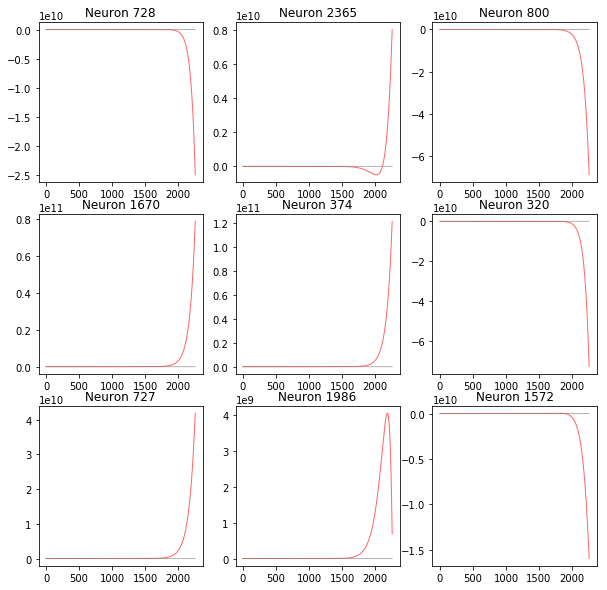

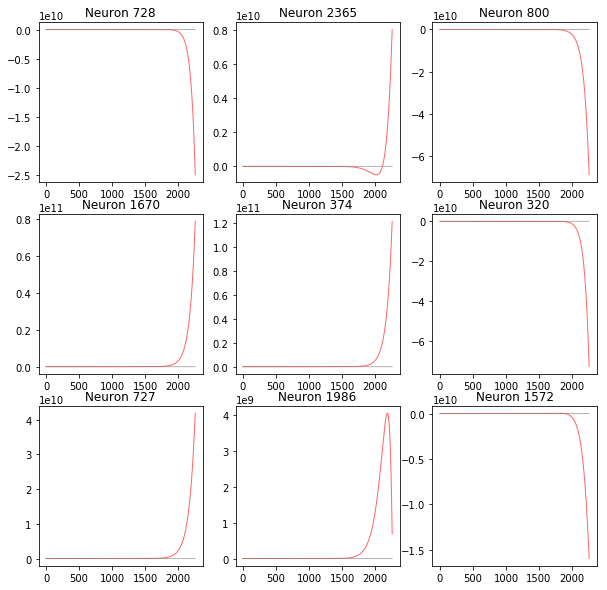

In [35]:
# pred = predict(model, test_data).squeeze()[:,0,:]
# pred = predict(model, data).squeeze()
pred = model.predict(U,P,X[0]).squeeze()

fig, ax = plt.subplots(3,3, figsize=(10,10))

# ax.set_ylabel("dx/dt")
# ax.set_xlabel("Time")
# ax.set_title("Training data")
dx_true = X[1:] - X[:-1]

for i in range(3):
    for j in range(3):
        n = np.random.randint(0,len(x_fish))
        ax[i,j].plot(pred[:,n].cpu().numpy(),color='red', alpha=0.6,linewidth=1, label="Model")
        ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=1, alpha=0.6,label="Truth")
        ax[i,j].set_title("Neuron {}".format(n))

fig